# Raman Rabi Tutorial

# Taylor Patti, Jamelle Watson-Daniels, and Soumya Ghosh

This is a tutorial notebook for the `raman_rabi` package. This tutorial uses example data to demonstrate how the package can be used to perform parameter estimation on spin readout data. This package was developed for Prof. Manoharan's PHYS 201: Statistics for Physicists course at Harvard.


## About the Model

We want to know if the functional form of the electronic-nuclear flip-flop transition in the Raman-Rabi NV center protocol is indeed the form of a decaying exponential.  [arXiv:1808.04346]. The data we are interested in is the change in $m_N = +1$ and $m_s = 0$ nuclear spin populations as a function of Raman-Rabi pulse length in Fig. 4.

It is hypothesized by the paper that this behavior is weakly driven, over-damped Raman-Rabi oscillations. That is, partial coherent transitions between the two nuclear spin populations marred by various sources of state decay and decoherence. The ideal theoretical model proposed for the nuclear spin specific fluorescence for spin $m_N$ is, $I_T^{m_N}(t)$, is described by

$$I_T^{m_N}(t) = B_G + A_p e^{-\Gamma_p t} + A_h \cos\left( \Omega_h t \right) e^{-\Gamma_{deph} t},$$

where $B_G$ is the background population/fluorescence, $A_p$ is the strength at which parasitic transitions remove states from the cycle (i.e. into $m_s = -1$ or $m_N = -1$ states, $\Gamma_p$ is the rate at which this parasitic loss occurs, $A_h$ is the strength at which the hyperfine interaction induces this transition, $\Omega_h$ is the rate at which the hyperfine transition occurs, and $\Gamma_{deph}$ is the rate of dephasing in this coherent oscillation. The units of $B_G$, $A_p$, and $A_h$ are arbitrary units of fluoresence (A.U.) and the units of $\Gamma_p$, $\Omega_h$, and $\Gamma_{deph}$ are inverse $\mu$s.

This week, we will be focusing on a basic analysis where we will average over all of our data points for each $m_S$ and then consider our full signal model as

$$I(t) = I_T^{m_N}(t) + \eta_{shot}(t)$$

where $\eta_{shot}(t)$ is a random variable describing the measurement shot noise (Poissonian distribution) of mean $\lambda = \sqrt{I_T^{m_N}(t)}$ is. This is because the expectation value of shot noise is equal to the square root of the ideal signal, the shot noise is described by a Poissonian distribution, and the expectation value of the Poissonian distribution is its mean. HOWEVER, as the fluoresence data is taken as a continuum (not single photon counting) we will take the limit of large counts of a Poissonian distribution and obtain a Gaussian distribution for the shot noise random variable.

# Run Unit tests

Now that we know the big picture, let's go to the root directory and run the unit tests:

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import raman_rabi
import numpy as np
from raman_rabi import RRDataContainer
from raman_rabi import rr_model

In [2]:
!nosetests

.....
----------------------------------------------------------------------
Ran 5 tests in 0.604s

OK


Now try importing the package itself to make sure it runs:

In [3]:
import raman_rabi

print(raman_rabi.testing.hello())

>>> Hello from raman_rabi!


# Load data

Data can be loaded using raman_rabi object `RRDataContainer` quite easily:

In [3]:
testfilepath = "testdata/21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt"
s = RRDataContainer(testfilepath)
mN1_data = s

Now let's initalize parameters based on our knowledge of the test data

In [6]:
time_min = 0
time_max = 40
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871

## Bayesian parameter estimation
Consider the test data against the model with nominal parameters, determined in the previous work. In order to illustrate the suitability of this functional form for these test data, let's plot the model with nominal parameters against the fluorescence data averaged over all runs. 

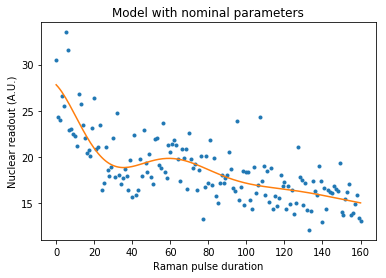

In [7]:
s_likelihood, prediction = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, 
                                                   Ap, Gammap, Ah, Omegah, Gammadeph)

conversion = 1000 # conversion factor between fluorescence and number of nuclei
averaged_data = conversion*s.get_df().mean(axis=0)
plt.plot(averaged_data,linestyle='None',marker='.')
plt.plot(prediction)
plt.title('Model with nominal parameters')
plt.xlabel('Raman pulse duration')
plt.ylabel('Nuclear readout (A.U.)')
plt.show()

In an effort to understand our likelihood function, let's vary $B_G$ and calculate the likelihood. Then, we do the same for $\Gamma_p$.

In [8]:
# Calculate likelihood as a function of the background fluorescence parameter
# and the parasitic loss rate parameter
npoints = 1000
BG_range = np.linspace(0,10,npoints)
gammap_range = np.linspace(-Gammap/2,2*Gammap,npoints)

likelihoods_bg = []
likelihoods_gp = []
mus_bg = []
mus_gp = []
for i in range(npoints):
    bgLikelihood, mu1 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG_range[i], Ap, Gammap, Ah, Omegah, Gammadeph)
    likelihoods_bg.append(bgLikelihood)
    gpLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, gammap_range[i], Ah, Omegah, Gammadeph)
    likelihoods_gp.append(gpLikelihood)

Now we can look at the plot of the range of background population/fluorescence versus likelihood

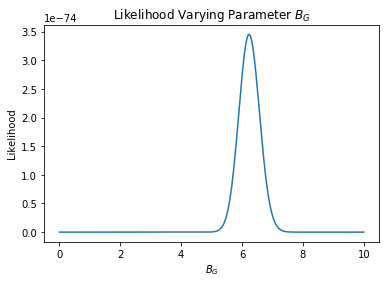

In [9]:
plt.plot(BG_range,likelihoods_bg)
plt.title(r"Likelihood Varying Parameter $B_G$")
plt.xlabel(r"$B_G$")
plt.ylabel("Likelihood")
plt.show()

Notice, we are peaked right around our nominal value. That gives you some idea of how the nominal values were chosen. Let's look at the plot for $\Gamma_p$ versus likehood calculation and you will notice the same thing.

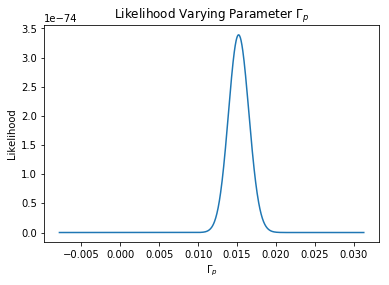

In [10]:
plt.plot(gammap_range,likelihoods_gp)
plt.title(r"Likelihood Varying Parameter $\Gamma_p$")
plt.xlabel(r"$\Gamma_p$")
plt.ylabel("Likelihood")
plt.show()

The values of $\Gamma_p$ and $B_G$ that maximize these likelihood scans correspond to the MAP values of these parameters with uniform priors for all parameters, as the likelihood function is proportional to the posterior.

In [11]:
print('>>> MAP value of B_G is', BG_range[np.argmax(likelihoods_bg)], 'A.U.')
print('>>> MAP value of Gamma_p is', gammap_range[np.argmax(likelihoods_gp)], ' us^-1')

>>> MAP value of B_G is 6.226226226226226 A.U.
>>> MAP value of Gamma_p is 0.015207613445576142  us^-1


This is a simple example of how you can use the raman_rabi package.